In [37]:
!pip install -q condacolab
import condacolab
condacolab.install()
# Install all your required packages here using mamba
!mamba install -q scikit-learn graph-tool

✨🍰✨ Everything looks OK!


In [36]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [44]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import graph_tool as gt

def visualize_threshold_graph_gt_weighted(unique_vectors, distance_threshold):
    """
    Builds a weighted graph with graph-tool where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.
    The edge is weighted by the real Euclidean distance between the nodes.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.

    Returns:
        g (graph_tool.Graph): The constructed weighted graph.
    """
    # Convert tensor to numpy array if necessary.
    X = unique_vectors

    n = X.shape[0]
    print(f"Building weighted graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold.
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='auto').fit(X)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph using graph-tool.
    g = gt.Graph(directed=False)
    g.add_vertex(n)  # Add n vertices

    # Build a list of edges with weights
    edge_list = []
    for i, (dists, neigh) in enumerate(zip(distances, indices)):
        # For each neighbor j of node i, add edge only if i < j to avoid duplicates.
        edge_list.extend([[i, j, d] for d, j in zip(dists, neigh) if i < j])

    # Convert the list of edges to a NumPy array (with float type to hold the weight)
    edge_array = np.array(edge_list)

    eweight = g.new_ep("float")
    # Add all edges at once
    g.add_edge_list(edge_array, eprops=[eweight])

    print(f"Weighted graph built with {g.num_edges()} edges.")
    return g

# Example usage:
g = visualize_threshold_graph_gt_weighted(unique_vectors, distance_threshold=6)


Building weighted graph for 6726 nodes...
Weighted graph built with 4681902 edges.


In [45]:
import numpy as np
import graph_tool.all as gt
import graph_tool.topology as gt_topo

def find_furthest_nodes_double_sweep_largest_component(g, X):
    """
    For a graph g (built with graph-tool) and an array X of shape (n, 784) corresponding to the
    unique vectors (with row i corresponding to vertex i), this function:
      1. Adds a vertex property to store original indices.
      2. Extracts the largest connected component.
      3. Finds two nodes that are farthest apart (approximate diameter endpoints) using a double-sweep algorithm
         on the subgraph.
      4. Computes the shortest path between them in the subgraph.
      5. Maps the subgraph vertices back to the original graph using the stored property.
      6. Extracts the corresponding 784-d vectors and computes delta vectors along the path.

    Returns:
      endpoints_sub: Tuple with the two endpoint indices in the subgraph (original indices).
      path_indices: List of original graph vertex indices along the shortest path.
      path_vectors: Array of the corresponding 784-d vectors for each vertex on the path.
      path_deltas: List of delta vectors between consecutive nodes on the path.
    """
    # --- Step 1: Store original vertex indices as a vertex property ---
    orig_index = g.new_vertex_property("int")
    for v in g.vertices():
        orig_index[v] = int(v)

    # --- Step 2: Extract the largest connected component ---
    comp, hist = gt.label_components(g)
    largest_comp = np.argmax(hist)
    vfilt = comp.a == largest_comp
    g_sub = gt.GraphView(g, vfilt=vfilt)

    # Build a mapping from subgraph vertex object to original graph index.
    vertex_to_orig = {v: int(orig_index[v]) for v in g_sub.vertices()}
    # Also, get a list of subgraph vertices.
    vertices_sub = list(g_sub.vertices())
    n_sub = len(vertices_sub)
    print(f"Largest connected component has {n_sub} vertices (out of {int(g.num_vertices())} total).")

    # --- Step 3: Double Sweep Algorithm on the subgraph ---
    # Use the list of vertices instead of range(n_sub)
    v0 = vertices_sub[0]
    dmap = gt.shortest_distance(g_sub, source=v0)
    # Find the vertex farthest from v0 among vertices_sub.
    farthest_idx = np.argmax([dmap[v] for v in vertices_sub])
    v1 = vertices_sub[farthest_idx]

    dmap2 = gt.shortest_distance(g_sub, source=v1)
    farthest_idx2 = np.argmax([dmap2[v] for v in vertices_sub])
    v2 = vertices_sub[farthest_idx2]

    endpoints_sub = (vertex_to_orig[v1], vertex_to_orig[v2])
    diameter_length = dmap2[v2]
    print("Diameter endpoints in subgraph (original indices):", endpoints_sub, "with length:", diameter_length)

    # --- Step 4: Compute the shortest path in the subgraph between v1 and v2 ---
    path_vertices_sub, _ = gt_topo.shortest_path(g_sub, source=v1, target=v2)
    # path_vertices_sub is a list of vertex objects in g_sub.
    print("Shortest path in subgraph (vertex objects):", list(path_vertices_sub))

    # --- Step 5: Map subgraph vertex objects back to original graph indices ---
    path_indices = [vertex_to_orig[v] for v in path_vertices_sub]
    print("Mapped original graph vertex indices for path:", path_indices)

    # --- Step 6: Extract the corresponding 784-d vectors and compute delta vectors ---
    path_vectors = X[path_indices]
    path_deltas = [path_vectors[i+1] - path_vectors[i] for i in range(len(path_vectors) - 1)]

    return endpoints_sub, path_indices, path_vectors, path_deltas

# Example usage:
# Assume unique_vectors is your NumPy array of shape (n, 784)
endpoints_sub, path_indices, path_vectors, path_deltas = find_furthest_nodes_double_sweep_largest_component(g, unique_vectors)

print("\n--- Results ---")
print("Furthest endpoints in subgraph (original indices):", endpoints_sub)
print("Path indices (original graph):", path_indices)
print("Path vectors shape:", np.array(path_vectors).shape)
print("Number of delta vectors:", len(path_deltas))


Largest connected component has 6631 vertices (out of 6726 total).
Diameter endpoints in subgraph (original indices): (6552, 0) with length: 10
Shortest path in subgraph (vertex objects): [<Vertex object with index '6552' at 0x7bbc88f0b140>, <Vertex object with index '2345' at 0x7bbc88f0acc0>, <Vertex object with index '6425' at 0x7bbc88f0b040>, <Vertex object with index '6439' at 0x7bbc88f0afc0>, <Vertex object with index '6168' at 0x7bbc88f0af40>, <Vertex object with index '1227' at 0x7bbc88f0aec0>, <Vertex object with index '4' at 0x7bbc88f0ae40>, <Vertex object with index '127' at 0x7bbc88f0adc0>, <Vertex object with index '2506' at 0x7bbc88f0ad40>, <Vertex object with index '1' at 0x7bbc88f0ac40>, <Vertex object with index '0' at 0x7bbcb5e8d7c0>]
Mapped original graph vertex indices for path: [6552, 2345, 6425, 6439, 6168, 1227, 4, 127, 2506, 1, 0]

--- Results ---
Furthest endpoints in subgraph (original indices): (6552, 0)
Path indices (original graph): [6552, 2345, 6425, 6439, 

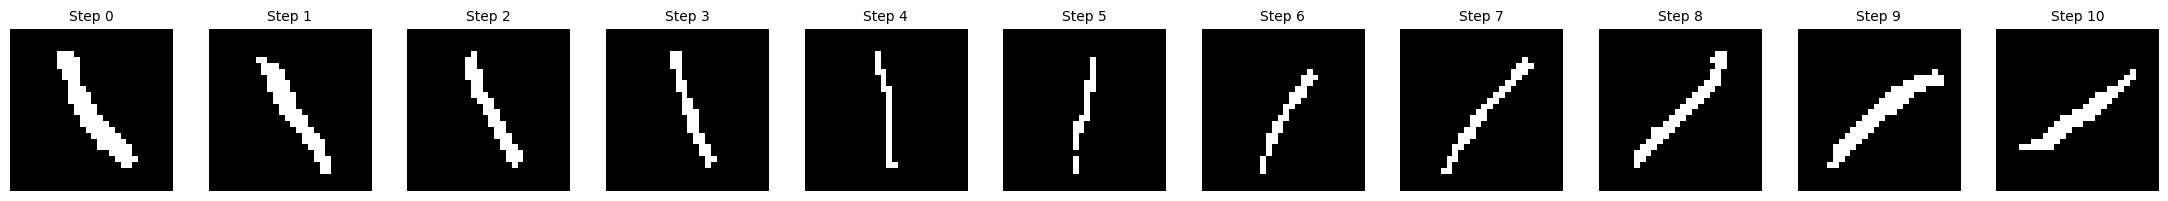

In [31]:
import matplotlib.pyplot as plt

def plot_path_as_images(path_vectors):
    """
    Given an array of 784-d vectors (each representing an MNIST image),
    reshapes them into 28x28 images and plots them side-by-side.

    Args:
        path_vectors (np.array): Array of shape (n_steps, 784)
    """
    num_steps = len(path_vectors)
    # Create a figure with one subplot per image along the path.
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))

    # If only one image, ensure axs is iterable.
    if num_steps == 1:
        axs = [axs]

    for i, vec in enumerate(path_vectors):
        img = vec.reshape(28, 28)
        axs[i].imshow(img, cmap='gray')
        axs[i].axis("off")
        axs[i].set_title(f"Step {i}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming path_vectors is the output from the previous function
plot_path_as_images(path_vectors)


In [32]:
import numpy as np

# Assume path_deltas is a list of 10 arrays, each of shape (784,)
# First, stack them into a 2D array with shape (10, 784)
deltas_array = np.stack(path_deltas)  # Shape: (10, 784)

# Transpose the array to get shape (784, 10)
deltas_by_dimension = deltas_array.T  # Each row now corresponds to a dimension

# If you need a list of 784 arrays (each of length 10)
deltas_list_by_dimension = [deltas_by_dimension[i, :] for i in range(deltas_by_dimension.shape[0])]

print("Shape of deltas_array (by path step):", deltas_array.shape)
print("Shape of deltas_by_dimension (by dimension):", deltas_by_dimension.shape)


Shape of deltas_array (by path step): (10, 784)
Shape of deltas_by_dimension (by dimension): (784, 10)


In [33]:
import numpy as np

# Assuming deltas_by_dimension is a NumPy array of shape (784, 10)
indices_with_one = np.where(np.any(deltas_by_dimension != 0, axis=1))[0]
print("Indices with at least one 1:", indices_with_one)

import numpy as np
import pandas as pd

# Assuming deltas_by_dimension is a numpy array of shape (784, 10)
# Compute the count of 1s for each row
ones_count = np.sum(deltas_by_dimension != 0, axis=1)

# Create a DataFrame with row numbers and count of 1s
df = pd.DataFrame({
    'Row': np.arange(deltas_by_dimension.shape[0]),
    "Count of 1's": ones_count
})

# Sort the DataFrame in descending order by the count of 1s
df_sorted = df.sort_values(by="Count of 1's", ascending=False)

# Display the sorted table
print(df_sorted)


Indices with at least one 1: [120 121 122 123 124 132 133 148 149 150 151 152 155 159 160 161 176 177
 178 179 180 183 188 189 190 205 206 207 208 209 211 214 215 216 217 219
 233 234 235 236 237 239 241 242 243 244 245 246 247 248 262 263 264 265
 266 267 269 270 271 272 273 274 275 276 290 291 292 293 294 295 296 297
 298 299 300 301 318 319 320 321 322 323 324 325 326 327 328 346 347 348
 349 350 351 352 353 354 355 375 376 377 378 379 380 381 382 403 404 405
 407 408 409 431 432 433 435 436 458 459 460 461 462 463 464 485 486 487
 488 489 490 491 492 493 512 513 514 515 516 518 519 520 521 522 538 539
 540 541 542 543 544 546 547 548 549 550 551 564 565 566 567 568 569 570
 571 572 574 575 576 577 578 579 580 594 595 596 597 599 602 604 605 606
 607 608 622 623 624 625 626 628 630 633 634 635 636 637 649 650 652 654
 656 658 659 661 662 663 664 679 680 682 684 691 692]
     Row  Count of 1's
350  350             4
322  322             4
296  296             4
265  265             4

In [40]:
import numpy as np
import graph_tool.all as gt

# Label connected components; comp is a property map with component labels,
# and hist contains the sizes of each component.
comp, hist = gt.label_components(g)

# Identify the label corresponding to the largest component.
largest_component_label = np.argmax(hist)

# Create a vertex filter that is True for vertices in the largest component.
vfilt = comp.a == largest_component_label

# Create a subgraph view using the vertex filter.
g_lcc = gt.GraphView(g, vfilt=vfilt)

print("Largest connected component has", g_lcc.num_vertices(), "vertices and", g_lcc.num_edges(), "edges.")


Largest connected component has 6631 vertices and 4681893 edges.


In [48]:
# Assume g is your original graph and it has a vertex property "orig_index"
orig_index_prop = g.vertex_properties["orig_index"]

# Build a mapping for vertices in the connected component
vertex_to_orig = {v: int(orig_index_prop[v]) for v in g_lcc.vertices()}


KeyError: ('v', 'orig_index')

In [47]:
import os
from PIL import Image
import numpy as np

# Ensure output directory exists
output_dir = "mnist1s"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the original index property from the original graph; it's inherited by the subgraph
orig_index = g.vertex_properties["orig_index"]

# Loop over vertices in the largest connected component (g_lcc)
for v in g_lcc.vertices():
    idx = int(orig_index[v])
    # Retrieve the corresponding 784-dimensional vector
    vector = unique_vectors[idx]  # vector of shape (784,)
    # Reshape into a 28x28 image and scale values from [0, 1] to [0, 255]
    image_array = (vector.reshape(28, 28) * 255).astype(np.uint8)
    img = Image.fromarray(image_array, mode="L")  # "L" mode for grayscale images
    # Save the image with the node's original index as filename
    img.save(os.path.join(output_dir, f"{idx}.png"))


KeyError: ('v', 'orig_index')